In [1]:
import librosa
from strechableNumpyArray import StrechableNumpyArray
import numpy as np
import os

pathToBaseDatasetFolder = 'sc09/'
folderNames = ['test']#, 'test', 'valid']
dirs = [pathToBaseDatasetFolder+folderName for folderName in folderNames]
audios = StrechableNumpyArray()
i = 0
total = 0
print('start')
for directory in dirs:
    file_names = os.listdir(directory)
    np.random.shuffle(file_names)
    for file_name in file_names:
        if file_name.endswith('.wav'):      
            audio, sr = librosa.load(directory + '/' + file_name, sr=None, dtype=np.float64)

            if len(audio) < 16000:
                before = int(np.floor((16000-len(audio))/2))
                after = int(np.ceil((16000-len(audio))/2))
                audio = np.pad(audio, (before, after), 'constant', constant_values=(0, 0))
            if len(audio) > 16000: 
                print(file_name, "is too long: ", len(audio))
            if np.sum(np.absolute(audio)) < len(audio)*1e-4: 
                print(file_name, "doesn't meet the minimum amplitude requirement")
                continue

            audios.append(audio[:16000])
            i+=1

            if i >= 10:
                print("there were:", total+i)
                break

audios = audios.finalize()
audios = np.reshape(audios, (total+i, len(audio))).astype(np.float64)
print("audios shape:", audios.shape)


start
there were: 10
audios shape: (10, 16000)


In [2]:
from IPython.display import display, Audio

for i in range(3):
    display(Audio(audios[i], rate=16000))

In [3]:
from ourLTFATStft import LTFATStft
import ltfatpy
from modGabPhaseGrad import modgabphasegrad
ltfatpy.gabphasegrad = modgabphasegrad # The original function is not implemented for one sided stfts on ltfatpy

fft_hop_size = 128
fft_window_length = 512
L = 16384
clipBelow = -10

anStftWrapper = LTFATStft()
spectrograms = np.zeros([len(audios), int(fft_window_length//2+1), int(L/fft_hop_size)], dtype=np.float64)
tgrads = np.zeros([len(audios), int(fft_window_length//2+1), int(L/fft_hop_size)], dtype=np.float64)
fgrads = np.zeros([len(audios), int(fft_window_length//2+1), int(L/fft_hop_size)], dtype=np.float64)
print(spectrograms.shape)
gs = {'name': 'gauss', 'M': fft_window_length}
    
for index, audio in enumerate(audios):
    realDGT = anStftWrapper.oneSidedStft(signal=audio, windowLength=fft_window_length, hopSize=fft_hop_size)
    spectrogram = anStftWrapper.logMagFromRealDGT(realDGT, clipBelow=np.e**clipBelow, normalize=True)
    spectrograms[index] = spectrogram  
    tgradreal, fgradreal = ltfatpy.gabphasegrad('abs', np.abs(realDGT), gs, fft_hop_size)
    tgrads[index] = tgradreal
    fgrads[index] = fgradreal


(10, 257, 128)


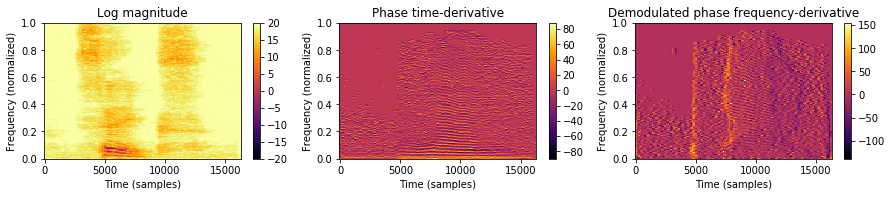

In [4]:
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt

c     = spectrograms[2]
tgrad = tgrads[0]
fgrad = fgrads[0]
a     = 128
M     = 512

mpl.rcParams['image.cmap'] =  'inferno'
plt.figure(figsize=(15,2.5));
plt.subplot(131);
ltfatpy.plotdgtreal(c,a,M,dynrange=40);
plt.title('Log magnitude')
plt.subplot(132);
ltfatpy.plotdgtreal(tgrad*(np.abs(c) > np.exp(-5)),a,M, normalization='lin');
plt.title('Phase time-derivative')
plt.subplot(133);
ltfatpy.plotdgtreal(fgrad*(np.abs(c) > np.exp(-5)),a,M, normalization='lin');
plt.title('Demodulated phase frequency-derivative');


In [5]:
import heapq

def pure_python_pghi(spectrogram, tgrad, fgrad, a, M, L, tol=10):
    abstol = -20
    done_mask = np.zeros_like(spectrogram)
    phase = np.zeros_like(spectrogram)
    max_val = np.amax(spectrogram[done_mask == 0])
    max_pos = np.where(spectrogram==max_val)
       
    if max_val <= abstol:  #Avoid integrating the phase for the spectogram of a silent signal
        print('Empty spectrogram')
        return phase

    M2 = spectrogram.shape[0]
    N = spectrogram.shape[1]
    b =  L / M  
    
    sampToRadConst =  2.0 * np.pi / L # Rescale the derivs to rad with step 1 in both directions
    tgradw = a * tgrad * sampToRadConst
    fgradw = - b * ( fgrad + np.arange(spectrogram.shape[1]) * a ) * sampToRadConst # also convert relative to freqinv convention
                 
    magnitude_heap = []
    heapq.heappush(magnitude_heap, (-max_val, max_pos)) # Start on max value 
    done_mask[max_pos] = 1
    done_mask[spectrogram < max_val-tol] = 3 # Do not integrate over small areas

    while True:
        while True:
            try:
                max_val, max_pos = heapq.heappop(magnitude_heap)
            except IndexError:
                break
            
            col = max_pos[0]
            row = max_pos[1]
            
            #Spread to 4 direct neighbors
            N_pos = col+1, row
            S_pos = col-1, row
            E_pos = col, row+1
            W_pos = col, row-1

            if max_pos[0] < M2-1 and not done_mask[N_pos]:
                phase[N_pos] = phase[max_pos] + (fgradw[max_pos] + fgradw[N_pos])/2
                done_mask[N_pos] = 2
                heapq.heappush(magnitude_heap, (-spectrogram[N_pos], N_pos))

            if max_pos[0] > 0 and not done_mask[S_pos]:
                phase[S_pos] = phase[max_pos] - (fgradw[max_pos] + fgradw[S_pos])/2
                done_mask[S_pos] = 2
                heapq.heappush(magnitude_heap, (-spectrogram[S_pos], S_pos))

            if max_pos[1] < N-1 and not done_mask[E_pos]:
                phase[E_pos] = phase[max_pos] + (tgradw[max_pos] + tgradw[E_pos])/2
                done_mask[E_pos] = 2
                heapq.heappush(magnitude_heap, (-spectrogram[E_pos], E_pos))

            if max_pos[1] > 0 and not done_mask[W_pos]:
                phase[W_pos] = phase[max_pos] - (tgradw[max_pos] + tgradw[W_pos])/2
                done_mask[W_pos] = 2
                heapq.heappush(magnitude_heap, (-spectrogram[W_pos], W_pos))
        
        try:
            max_val = np.amax(spectrogram[done_mask == 0])
            max_pos = np.where(spectrogram==max_val)
        except ValueError:
            return phase
        heapq.heappush(magnitude_heap, (-max_val, max_pos))
        done_mask[max_pos] = 1

In [8]:
import heapq
import numba
from numba import njit

@njit
def pghi(spectrogram, tgrad, fgrad, a, M, L, tol=10):
    spectrogram = spectrogram.copy() 
    abstol = -20
    phase = np.zeros_like(spectrogram)
    max_val = np.amax(spectrogram)
    max_x, max_y = np.where(spectrogram==max_val)
    max_pos = max_x[0], max_y[0]
       
    if max_val <= abstol:  #Avoid integrating the phase for the spectogram of a silent signal
        print('Empty spectrogram')
        return phase

    M2 = spectrogram.shape[0]
    N = spectrogram.shape[1]
    b =  L / M  
    
    sampToRadConst =  2.0 * np.pi / L # Rescale the derivs to rad with step 1 in both directions
    tgradw = a * tgrad * sampToRadConst
    fgradw = - b * ( fgrad + np.arange(spectrogram.shape[1]) * a ) * sampToRadConst # also convert relative to freqinv convention
             
    magnitude_heap = [(-max_val, max_pos)]
#     heapq.heappush(magnitude_heap, (-max_val, max_pos)) # Start on max value 
    spectrogram[max_pos] = abstol
    
    small_x, small_y = np.where(spectrogram < max_val-tol)
    for x, y in zip(small_x, small_y):
        spectrogram[x, y] = abstol # Do not integrate over small areas

    while True:
        while len(magnitude_heap) > 0:
            max_val, max_pos = heapq.heappop(magnitude_heap)
            
            col = max_pos[0]
            row = max_pos[1]
            
            #Spread to 4 direct neighbors
            N_pos = col+1, row
            S_pos = col-1, row
            E_pos = col, row+1
            W_pos = col, row-1

            if max_pos[0] < M2-1 and spectrogram[N_pos] > abstol:
                phase[N_pos] = phase[max_pos] + (fgradw[max_pos] + fgradw[N_pos])/2
                heapq.heappush(magnitude_heap, (-spectrogram[N_pos], N_pos))
                spectrogram[N_pos] = abstol

            if max_pos[0] > 0 and spectrogram[S_pos] > abstol:
                phase[S_pos] = phase[max_pos] - (fgradw[max_pos] + fgradw[S_pos])/2
                heapq.heappush(magnitude_heap, (-spectrogram[S_pos], S_pos))
                spectrogram[S_pos] = abstol

            if max_pos[1] < N-1 and spectrogram[E_pos] > abstol:
                phase[E_pos] = phase[max_pos] + (tgradw[max_pos] + tgradw[E_pos])/2
                heapq.heappush(magnitude_heap, (-spectrogram[E_pos], E_pos))
                spectrogram[E_pos] = abstol

            if max_pos[1] > 0 and spectrogram[W_pos] > abstol:
                phase[W_pos] = phase[max_pos] - (tgradw[max_pos] + tgradw[W_pos])/2
                heapq.heappush(magnitude_heap, (-spectrogram[W_pos], W_pos))
                spectrogram[W_pos] = abstol
        
        max_val = np.amax(spectrogram)
        if max_val <= abstol:
            return phase

        max_x, max_y = np.where(spectrogram==max_val)
        max_pos = max_x[0], max_y[0]
        heapq.heappush(magnitude_heap, (-max_val, max_pos))
        spectrogram[max_pos] = abstol


In [10]:
np.testing.assert_array_equal(pure_python_pghi(spectrograms[2], tgrads[2], fgrads[2], a, M, L, tol=8), pghi(spectrograms[2], tgrads[2], fgrads[2], a, M, L, tol=8))

In [7]:
fgrads[2].shape

(257, 128)

In [14]:
a     = 128
M     = 512

reconstructed_audios = StrechableNumpyArray()
for i in range(len(audios)):
    phase = pghi(spectrograms[i], tgrads[i], fgrads[i], a, M, L, tol=8)
    reconstructed_audios.append(anStftWrapper.reconstructSignalFromLoggedSpectogram(spectrograms[i], phase, windowLength=fft_window_length, hopSize=fft_hop_size))

reconstructed_audios = reconstructed_audios.finalize()
reconstructed_audios = np.reshape(reconstructed_audios, (len(audios), -1)).astype(np.float64)
print("reconstructed audios shape:", reconstructed_audios.shape)


reconstructed audios shape: (10, 16384)


In [12]:
%timeit pure_python_pghi(spectrograms[2], tgrads[2], fgrads[i], a, M, L, tol=8)

781 ms ± 1.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%timeit pghi(spectrograms[2], tgrads[2], fgrads[2], a, M, L, tol=8)
# .py_func(x)

7.54 ms ± 5.25 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


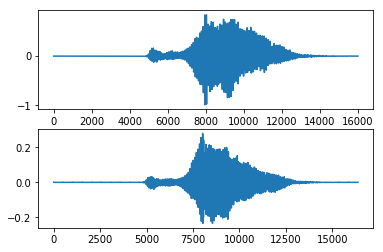

In [15]:
plt.subplot(211)
plt.plot(audios[0])
plt.subplot(212)
plt.plot(reconstructed_audios[0])
display(Audio(audios[0], rate=16000))
display(Audio(reconstructed_audios[0], rate=16000))

In [16]:
for i in range(10):
    display(Audio(audios[i], rate=16000))
    display(Audio(reconstructed_audios[i], rate=16000))